In [5]:
import numpy as np
import os
from datetime import datetime
from argparse import ArgumentParser
from tqdm import tqdm
import scipy.ndimage

import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter

from src.models.model_factory import build_model, build_criterion
from src.data.data_factory import build_dataloaders
from src.utils.configs import get_default_configuration, load_config
from src.utils.confusion import BinaryConfusionMatrix
from src.data.nuscenes.utils import NUSCENES_CLASS_NAMES
from src.data.argoverse.utils import ARGOVERSE_CLASS_NAMES
from src.utils.visualise import colorise
import matplotlib.pyplot as plt

import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor
from argoverse.data_loading.argoverse_tracking_loader \
    import ArgoverseTrackingLoader
from argoverse.utils.camera_stats import RING_CAMERA_LIST

from src.data.argoverse.utils import IMAGE_WIDTH, IMAGE_HEIGHT, ARGOVERSE_CLASS_NAMES
from src.data.utils import decode_binary_labels
import cv2

In [10]:
# Set up path to data
ARGOVERSE_DATA_ROOT = './data/argo/argoverse-tracking/'
split = 'val'
split_data_dir = ARGOVERSE_DATA_ROOT + split
data_root_split = os.path.join(ARGOVERSE_DATA_ROOT, split)
# log_id = '10b8dee6-778f-33e4-a946-d842d2d9c3d7'
log_id = '5ab2697b-6e3e-3454-a36a-aba2c6f27818'
camera_name = 'ring_front_center'
# cam_timestamp = '315968229010581848'

# img_fpath = f'{split_data_dir}/{log_id}/{camera_name}/{camera_name}_{cam_timestamp}.jpg'
LABEL_ROOT = 'data/argo/labels/'
MASK_ROOT = './data/argo/masks_warped'
mask_folder = os.path.join(MASK_ROOT, split, log_id, camera_name)

In [7]:
def load_labels(split, log, camera, timestamp):
    # Construct label path from example data
                            
    label_path = os.path.join(LABEL_ROOT, split, log, camera, 
                                f'{camera}_{timestamp}.png')
    
    if not os.path.exists(label_path):
        return None, None
    # Load encoded label image as a torch tensor
    encoded_labels = to_tensor(Image.open(label_path)).long()

    # Decode to binary labels
    num_class = len(ARGOVERSE_CLASS_NAMES)
    labels = decode_binary_labels(encoded_labels, num_class+ 1)
    labels, mask = labels[:-1], ~labels[-1]

    return labels, mask

In [12]:
from matplotlib.cm import get_cmap

def colorise(arr, cmap, vmin=None, vmax=None):

    if isinstance(cmap, str):
        cmap = get_cmap(cmap)
    

    vmin = float(arr.min()) if vmin is None else vmin
    vmax = float(arr.max()) if vmax is None else vmax

    arr = (arr - vmin) / (vmax - vmin)
    return cmap(arr)[..., :3]

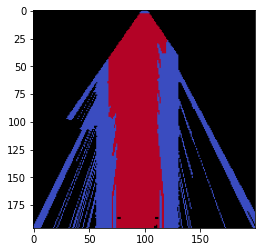

In [21]:
sem_mask_names = sorted(os.listdir(mask_folder))
idx = 0
sem_mask_name = sem_mask_names[idx]
sem_mask = np.load(os.path.join(mask_folder, sem_mask_name))

drivable_mask = sem_mask == 1
vehicle_mask = sem_mask == 14
pedestrain_mask = sem_mask == 12

drivable_mask = colorise(drivable_mask, 'coolwarm', 0, 1) * 255
vehicle_mask = colorise(vehicle_mask, 'coolwarm', 0, 1) * 255
pedestrain_mask = colorise(pedestrain_mask, 'coolwarm', 0, 1) * 255

cam_timestamp = sem_mask_name.split('.')[0].split('_')[-1]
labels, mask = load_labels(split, log_id, camera_name, cam_timestamp)
obstacles = mask == 0
drivable_mask[obstacles] = 0
vehicle_mask[obstacles] = 0
pedestrain_mask[obstacles] = 0

drivable_mask = drivable_mask.astype(np.uint8)
cv2.imwrite("ipm_drivable_mask.jpg", cv2.cvtColor(drivable_mask, cv2.COLOR_RGB2BGR))
plt.figure()
plt.imshow(drivable_mask)

vehicle_mask = vehicle_mask.astype(np.uint8)
cv2.imwrite("ipm_vehicle_mask.jpg", cv2.cvtColor(vehicle_mask, cv2.COLOR_RGB2BGR))
plt.figure()
plt.imshow(vehicle_mask)

pedestrain_mask = pedestrain_mask.astype(np.uint8)
cv2.imwrite("ipm_pedestrain_mask.jpg", cv2.cvtColor(pedestrain_mask, cv2.COLOR_RGB2BGR))
plt.figure()
plt.imshow(pedestrain_mask)